# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [198]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [199]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [200]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [201]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [202]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [203]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [204]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [205]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [206]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [207]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [208]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [209]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [210]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

In [211]:
##Sorting data for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final.shape)
final.head()

(100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
10291,11237,B001KVPC0G,AY74M03WTAOMB,Nut Nut,0,0,1,1226534400,Best Roasted Almonds,I've tried several other brands of roasted sal...
79814,86781,B002DHBT7Q,A1CHKAWX7FAOM4,"L. Kirk ""Crabseye""",2,2,1,1317600000,One of my favorite cookies,"A cookie a day (or 2, depending on serving siz..."
76651,83391,B005ZBZLT4,A2QOYXPT6POXQS,Tony Barnes,0,0,1,1349049600,Great deal!,This coffee is a great deal! All the coffee d...
40580,44095,B00168ACG2,AO26QTL5I5JRF,Suzanne Davis,0,0,1,1346112000,THIS IS THE BEST CORNBREAD!!!!,I have been eating this cornbread for years an...
64314,69846,B002B8ODPW,A2ZE8BSZ5MMEOP,"Jasmine ""Uniquely Yours""",0,0,1,1343520000,Convenient and tasty,"Not my favorite, but for the price great produ..."


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [212]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I've tried several other brands of roasted salted almonds available via the Internet and in stores.  The Blue Diamond brand is definitely the best tasting of all.
The stigma of decafs, in general, has vanished! Emeril's Jazzed Up Decaf is, by far, the richest and finest brew around. It is not "almost" coffee. It IS coffee, with more jazz and less BAM! Having to take medication at night I have found the perfect decaf companion. I have served it to many people who say it is the best coffee they have drunk. Sure, they were impressed by the Keuring machine... but the coffee stole the show. And the guests had no idea they were drinking decaf. It just doesn't get any better...
This is not a traditional cookie!  However, it is a good thing: it is its own little niche of yumminess. The fig flavor is very subtle--if you want full on fig, get the regular Newtons. This is a thinner wafer cookie, nicely crisp without being too dry.  It tastes healthy without tasting bland, if that makes any sense?

In [213]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I've tried several other brands of roasted salted almonds available via the Internet and in stores.  The Blue Diamond brand is definitely the best tasting of all.


In [214]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I've tried several other brands of roasted salted almonds available via the Internet and in stores.  The Blue Diamond brand is definitely the best tasting of all.
The stigma of decafs, in general, has vanished! Emeril's Jazzed Up Decaf is, by far, the richest and finest brew around. It is not "almost" coffee. It IS coffee, with more jazz and less BAM! Having to take medication at night I have found the perfect decaf companion. I have served it to many people who say it is the best coffee they have drunk. Sure, they were impressed by the Keuring machine... but the coffee stole the show. And the guests had no idea they were drinking decaf. It just doesn't get any better...
This is not a traditional cookie!  However, it is a good thing: it is its own little niche of yumminess. The fig flavor is very subtle--if you want full on fig, get the regular Newtons. This is a thinner wafer cookie, nicely crisp without being too dry.  It tastes healthy without tasting bland, if that makes any sense?

In [215]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [216]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is not a traditional cookie!  However, it is a good thing: it is its own little niche of yumminess. The fig flavor is very subtle--if you want full on fig, get the regular Newtons. This is a thinner wafer cookie, nicely crisp without being too dry.  It tastes healthy without tasting bland, if that makes any sense? You feel good eating these things--a treat but without the guilt.<br /><br />I am used to making my own cookies so to me anything store bought suffers a bit tastewise (compare a Chips Ahoy to a homemade cookie and you will know what I mean), but these are tasty right  out of the box.<br /><br />I do prefer the regular fig newtons, because I like the chewiness of the figs and the stronger fig taste, but these are a nice snack packable option.


In [217]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I've tried several other brands of roasted salted almonds available via the Internet and in stores.  The Blue Diamond brand is definitely the best tasting of all.


In [218]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is not a traditional cookie However it is a good thing it is its own little niche of yumminess The fig flavor is very subtle if you want full on fig get the regular Newtons This is a thinner wafer cookie nicely crisp without being too dry It tastes healthy without tasting bland if that makes any sense You feel good eating these things a treat but without the guilt br br I am used to making my own cookies so to me anything store bought suffers a bit tastewise compare a Chips Ahoy to a homemade cookie and you will know what I mean but these are tasty right out of the box br br I do prefer the regular fig newtons because I like the chewiness of the figs and the stronger fig taste but these are a nice snack packable option 


In [219]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [220]:
# Combining all the above stundents 
from tqdm import tqdm
prepr_rev = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    prepr_rev.append(sentance.strip())

100%|██████████| 100000/100000 [00:46<00:00, 2145.59it/s]


In [221]:
print(len(prepr_rev))
final.shape

100000


(100000, 10)

In [222]:
prepr_rev[1500]

'not traditional cookie however good thing little niche yumminess fig flavor subtle want full fig get regular newtons thinner wafer cookie nicely crisp without dry tastes healthy without tasting bland makes sense feel good eating things treat without guilt used making cookies anything store bought suffers bit tastewise compare chips ahoy homemade cookie know mean tasty right box prefer regular fig newtons like chewiness figs stronger fig taste nice snack packable option'

In [223]:
final ['prepr_rev']= prepr_rev
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,prepr_rev
10291,11237,B001KVPC0G,AY74M03WTAOMB,Nut Nut,0,0,1,1226534400,Best Roasted Almonds,I've tried several other brands of roasted sal...,tried several brands roasted salted almonds av...
79814,86781,B002DHBT7Q,A1CHKAWX7FAOM4,"L. Kirk ""Crabseye""",2,2,1,1317600000,One of my favorite cookies,"A cookie a day (or 2, depending on serving siz...",cookie day depending serving size one indulgen...
76651,83391,B005ZBZLT4,A2QOYXPT6POXQS,Tony Barnes,0,0,1,1349049600,Great deal!,This coffee is a great deal! All the coffee d...,coffee great deal coffee drinkers house enjoy ...
40580,44095,B00168ACG2,AO26QTL5I5JRF,Suzanne Davis,0,0,1,1346112000,THIS IS THE BEST CORNBREAD!!!!,I have been eating this cornbread for years an...,eating cornbread years could not find locally ...
64314,69846,B002B8ODPW,A2ZE8BSZ5MMEOP,"Jasmine ""Uniquely Yours""",0,0,1,1343520000,Convenient and tasty,"Not my favorite, but for the price great produ...",not favorite price great product handy stores ...


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [224]:
## Similartly you can do preprocessing for review summary also.

preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary) # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

100%|██████████| 100000/100000 [00:29<00:00, 3428.23it/s]


In [225]:
prepr_rev = [i + ' ' + j for i, j in zip(prepr_rev,preprocessed_summary)] 
print(prepr_rev[1500])

not traditional cookie however good thing little niche yumminess fig flavor subtle want full fig get regular newtons thinner wafer cookie nicely crisp without dry tastes healthy without tasting bland makes sense feel good eating things treat without guilt used making cookies anything store bought suffers bit tastewise compare chips ahoy homemade cookie know mean tasty right box prefer regular fig newtons like chewiness figs stronger fig taste nice snack packable option really yummy


# [4] Featurization

## [4.1] BAG OF WORDS

In [226]:
X = np.array(prepr_rev)
y = np.array(final['Score'])

In [227]:
from sklearn.model_selection import train_test_split
#splitting data into Train, C.V and Test
X_train, X_test, y_train, y_test = train_test_split(final ['prepr_rev'], final['Score'], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print("Train:",X_train.shape,y_train.shape)
print("CV:",X_cv.shape,y_cv.shape)
print("Test:",X_test.shape,y_test.shape)

Train: (44890,) (44890,)
CV: (22110,) (22110,)
Test: (33000,) (33000,)


In [228]:
vectorizer = CountVectorizer(min_df=10, max_features=500) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.3] TF-IDF

In [229]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test) 
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape) 
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape) 

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.4] Word2Vec

In [230]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

[('fantastic', 0.8478500843048096), ('good', 0.8255733251571655), ('awesome', 0.8136032223701477), ('wonderful', 0.7817325592041016), ('amazing', 0.734600305557251), ('perfect', 0.7340083122253418), ('incredible', 0.7206707000732422), ('excellent', 0.7106431722640991), ('terrific', 0.7058757543563843), ('nice', 0.6810044050216675)]
[('best', 0.7517200708389282), ('nastiest', 0.7383694648742676), ('greatest', 0.7120794057846069), ('tastiest', 0.6943706274032593), ('awful', 0.6782271265983582), ('horrible', 0.6637294888496399), ('yuck', 0.6547082662582397), ('disgusting', 0.6531492471694946), ('softest', 0.6466982364654541), ('weakest', 0.6367669105529785)]
number of words that occured minimum 5 times  12960


In [231]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12960
sample words  ['tea', 'go', 'everyday', 'nearly', 'indestructible', 'forgotten', 'steeped', 'minutes', 'still', 'tastes', 'great', 'brew', 'put', 'travel', 'mug', 'gym', 'hour', 'half', 'later', 'ca', 'not', 'beat', 'value', 'either', 'bag', 'recall', 'correctly', 'stash', 'store', 'oregon', 'got', 'drinking', 'green', 'awesome', 'keep', 'stirring', 'sits', 'long', 'taste', 'little', 'prep', 'time', 'keeps', 'going', 'day', 'delicious', 'sweetener', 'pure', 'nuts', 'chocolate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [166]:
i=0
sent_of_test_cv=[]
for sentance in X_cv:
    sent_of_test_cv.append(sentance.split())

In [167]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 22110/22110 [01:05<00:00, 336.99it/s]

(22110, 50)
[-0.52553881 -0.56571381  0.63142397  0.43928345  0.59151121  0.34461575
  0.18870962  0.45058656 -0.82038542 -0.29991521  0.56942672 -0.67313881
 -0.71965228 -0.07363756  0.2739284   0.0503723   0.52536564  0.63691369
  0.18458937  0.23666228 -0.32867154 -0.15568994  0.09874957 -0.01075351
  0.33511867  1.14519034  0.29567677 -0.0468841  -0.03616501  0.08883335
 -0.36886215 -0.42454403 -0.57793536  0.37274055 -0.06555429  0.18378313
  0.30609365 -0.04986344  0.03503402  0.93081964 -0.07000684 -0.54992588
  0.2967225   0.18228281  0.0962322   0.48645934 -0.23933173  0.25615076
  0.29496165 -0.3852263 ]


In [168]:
# compute average word2vec for X_test .
test_vectors = []; 
for sent in tqdm(sent_of_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)  
    
test_vectors = np.array(test_vectors)

print(test_vectors.shape)
print(test_vectors[0])    


100%|██████████| 33000/33000 [01:37<00:00, 338.26it/s]


(33000, 50)
[-0.19294365 -0.66535483  0.49491829  0.61472203  0.43786552 -0.2212762
  0.63726501 -0.09604544 -1.01787599 -0.38894434 -0.02899949 -0.36255753
 -0.46169367 -0.24737216 -0.55879127  0.22363069  0.50083397  0.24539507
 -0.0535983   0.33607479  0.03222066 -0.15921549  0.32272275  0.31025571
  0.21540802  0.19478748 -0.61918377 -0.0017801  -0.71217188 -0.46075358
 -0.54823264 -0.17418158 -0.12233295 -0.03316205 -0.08219504  0.14051325
 -0.26644893  0.27429939 -0.4835991   0.73440272  0.55616765 -0.06391602
 -0.40270575 -0.12931861 -0.24423024  0.236344    0.26991326  0.16444251
 -0.22399055  0.54960559]


In [169]:
# compute average word2vec for X_train .
train_vectors = []; 
for sent in tqdm(sent_of_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
train_vectors = np.array(train_vectors)

print(train_vectors.shape)
print(train_vectors[0])

100%|██████████| 44890/44890 [02:09<00:00, 346.49it/s]

(44890, 50)
[-0.14060537 -0.72614364  0.32810215  1.11755044  0.23384139  0.28288134
 -0.01866034 -0.04290673 -0.52098112 -0.01752026 -0.01945195  0.15767466
 -0.07230324 -0.01717835 -0.27854393  0.05381443  0.73443291  0.75394678
  0.93170925  0.04095242 -0.49682882 -0.20451759  0.2238511   0.65370598
 -0.13699235 -0.40837955  0.57271826 -0.12713724 -0.59230489 -0.02618843
 -0.34113196 -0.33512895 -0.13026007 -0.22999276  0.30137488  0.37416903
  0.2087824   0.68820576  0.2217927   0.66206925  0.37959712  0.22534903
 -0.7366674  -0.62474787  0.04708067  0.12064839  0.31486852  0.38119362
  0.3194624  -0.3280405 ]


[4.4.1.2] TFIDF weighted W2v

In [170]:
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    
tfidf_test_vectors = np.array(tfidf_test_vectors)
print(tfidf_test_vectors.shape)
print(tfidf_test_vectors[0])

100%|██████████| 33000/33000 [22:17<00:00, 24.67it/s]


(33000, 50)
[-0.16686663 -0.86323916  0.49690235  0.5184359   0.56615715 -0.54148702
  0.93596545 -0.25554939 -1.12918029 -0.77515194  0.04043236 -0.01329734
 -0.5751481  -0.6871599  -0.75427953  0.1534776   0.36420995  0.26531452
  0.08081806  0.42276238  0.15202629 -0.0840503   0.46600952  0.41430244
  0.26516221 -0.03617444 -0.87445306 -0.01075618 -0.63894613 -0.59917669
 -0.83022163 -0.19207686  0.0749336  -0.06149395 -0.1844047   0.28045885
 -0.81266072  0.22030619 -0.57452736  0.7226248   0.6758246   0.15453529
 -0.08191958  0.15770662 -0.32205749  0.08399961  0.39292019  0.16717439
 -0.39050156  0.80903407]


In [171]:
# compute TFIDF Weighted Word2Vec for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)

tfidf_train_vectors = np.array(tfidf_train_vectors)
print(tfidf_train_vectors.shape)
print(tfidf_train_vectors[0])

100%|██████████| 44890/44890 [27:49<00:00, 26.89it/s]  


(44890, 50)
[-0.29540099 -0.85954222 -0.18179773  0.88866737  0.38733377  0.07670469
 -0.08424611  0.12395096 -0.48383716 -0.07993022 -0.00500073  0.31535502
  0.06399823  0.02668346 -0.39874532 -0.19141424  0.41162859  0.67405128
  1.09345726  0.07239559 -0.44772274  0.12750844  0.26261354  0.38511071
 -0.16009767 -0.39785692  1.16591441 -0.4437846  -0.38423109  0.32179244
 -0.11075185 -0.21630509  0.073712   -0.27370394  0.21916168  0.2249126
 -0.02694394  0.95540116  0.0286596   0.38618412  0.51026674  0.42937773
 -0.9517379  -0.66895635  0.19392165 -0.37172587  0.3754621   0.14247962
  0.01241208 -0.48043844]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [232]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def lr_all (X_train,y_train,X_cv,penal):
    train_auc = []
    cv_auc = []
    hyper_param = [0.001, 0.01, 0.1, 1, 10, 100,1000]

    for i in tqdm(hyper_param):
        lr = LogisticRegression(C=i,penalty= penal)
        lr.fit(X_train_bow,y_train)

    
    
        y_train_pred =  lr.predict_proba(X_train_bow)[:,1]
        y_cv_pred = lr.predict_proba(X_cv_bow)[:,1]
    
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
     
    #Plotting the AUC curve for train and test data

    #Print the graph

    # https://stackoverflow.com/questions/28077499/matplotlib-pyplot-plot-x-axis-ticks-in-equal-range 
 
    plt.plot(np.log(hyper_param), train_auc, label='Train AUC-L1') 
    plt.plot(np.log(hyper_param), cv_auc, label='CV AUC-L1')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Lambda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    #Cv-auc scores with penalty L1
    print("--------------------------")
    print("Cv auc scores with penalty L1")
    print(cv_auc)
    print("Maximun Auc value :",max(cv_auc))
    print("Index",cv_auc.index(max(cv_auc)))
    
    #Get lambda value for max auc in cv data
    mx = 0
    for i in range(len(cv_auc)):
        if(cv_auc[i]> cv_auc[mx]):
            mx = i
    best = hyper_param[mx] 
    print("The optimal value of Lambda = ", best)
    
    
    
    lr = LogisticRegression(C =best,penalty= 'l1', class_weight = 'balanced')
    lr.fit(X_train_bow,y_train)



    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_bow)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_bow)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Lamda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
     

    #Confusion Matrix
    
    print("Train confusion matrix") 
    print(confusion_matrix(y_train, lr.predict(X_train_bow))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, lr.predict(X_test_bow)))
 
    cm = confusion_matrix(y_train, lr.predict(X_train_bow))
    cm = confusion_matrix(y_test, lr.predict(X_test_bow))
    tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()

100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


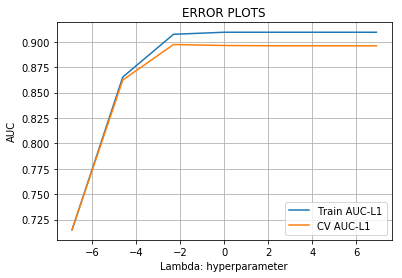

--------------------------
Cv auc scores with penalty L1
[0.7149699199648194, 0.8623282056497347, 0.8972412121357145, 0.8963105754704795, 0.8960072967579379, 0.8959743791218008, 0.895969632999947]
Maximun Auc value : 0.8972412121357145
Index 2
The optimal value of Lambda =  0.1


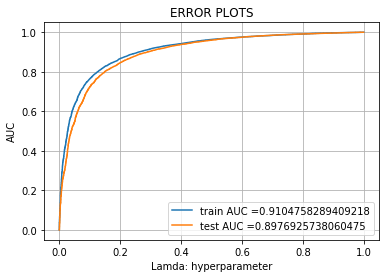

Train confusion matrix
[[ 6174  1081]
 [ 6539 31096]]
Test confusion matrix
[[ 4191   917]
 [ 4831 23061]]


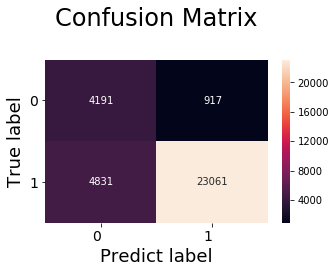

In [233]:
lr_all(X_train_bow,y_train,X_cv_bow,'l1')

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [236]:
def all_lr (X_train,y_train,X_cv,penal):
    train_auc_l2 = []
    cv_auc_l2 = []
    hyper_param = [0.001, 0.01, 0.1, 1, 10, 100,1000]

    for i in tqdm(hyper_param):
        lr = LogisticRegression(C=i,penalty= penal)
        lr.fit(X_train_bow,y_train)

    
    
        y_train_pred =  lr.predict_proba(X_train_bow)[:,1]
        y_cv_pred = lr.predict_proba(X_cv_bow)[:,1]
    
        train_auc_l2.append(roc_auc_score(y_train,y_train_pred))
        cv_auc_l2.append(roc_auc_score(y_cv, y_cv_pred))
     
    #Plotting the AUC curve for train and test data

    #Print the graph

    # https://stackoverflow.com/questions/28077499/matplotlib-pyplot-plot-x-axis-ticks-in-equal-range 


    plt.plot(np.log(hyper_param), train_auc_l2, label='Train AUC-L2') 
    plt.plot(np.log(hyper_param), cv_auc_l2, label='CV AUC-L2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Lambda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    #Cv auc scores with penalty L2
    print("--------------------------")
    print("Cv auc scores with penalty L2")
    print(cv_auc_l2)
    print("Maximun Auc value :",max(cv_auc_l2))
    print("Index",cv_auc_l2.index(max(cv_auc_l2)))
    
    
    
    

    
    #Get lambda value for max auc in cv data
    mx = 0
    for i in range(len(cv_auc_l2)):
        if(cv_auc_l2[i]> cv_auc_l2[mx]):
            mx = i
    best = hyper_param[mx] 
    print("The optimal value of Lambda = ", best)
    
    
    lr = LogisticRegression(C= best, penalty= 'l2', class_weight = 'balanced')
    lr.fit(X_train_bow,y_train)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, lr.predict_proba(X_train_bow)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test_bow)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("Lamda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
     

    #Confusion Matrix
    
    print("Train confusion matrix") 
    print(confusion_matrix(y_train, lr.predict(X_train_bow))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, lr.predict(X_test_bow)))
 
    cm = confusion_matrix(y_train, lr.predict(X_train_bow))
    cm = confusion_matrix(y_test, lr.predict(X_test_bow))
    tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()   
      

100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


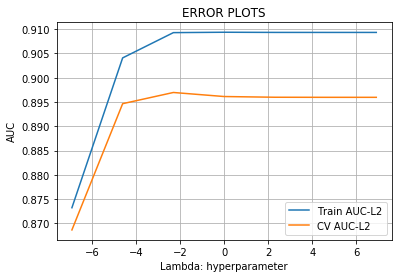

--------------------------
Cv auc scores with penalty L2
[0.8686668268851596, 0.8946634880571093, 0.8969706221466804, 0.8961376090875506, 0.8959898841372461, 0.8959746232952724, 0.895973127732759]
Maximun Auc value : 0.8969706221466804
Index 2
The optimal value of Lambda =  0.1


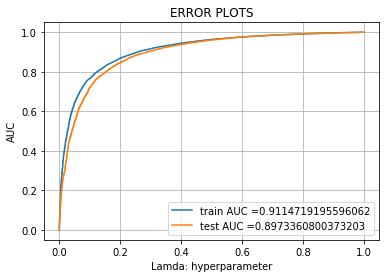

Train confusion matrix
[[ 6162  1093]
 [ 6475 31160]]
Test confusion matrix
[[ 4192   916]
 [ 4798 23094]]


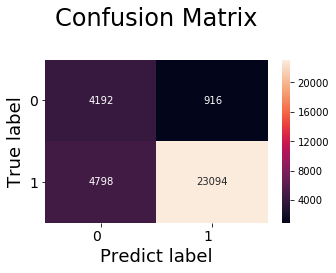

In [237]:
all_lr(X_train_bow,y_train,X_cv_bow,'l2')

In [238]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(lr.coef_[0])[2]
print(weights1[:10])

[ 0.15021456 -0.03929764 -0.05173317  0.43961426  0.05990978 -0.27028027
 -0.5902203  -0.13474628 -0.55136027  0.12501951]


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [239]:
# Please write all the code with proper documentation

lr = LogisticRegression(C=10,penalty='l2')
lr.fit(X_train_bow,y_train)
weight1 = lr.coef_ # the weight vector

# New dataset by adding a small noise
new_train = X_train_bow.astype(float)
new_train.data += np.random.uniform(-0.0001,0.0001,1 )

# Fit the model on new data
lr = LogisticRegression(C=1,penalty='l2')
lr.fit(X_train_bow,y_train)
weight2 =lr.coef_


weight1 += 10**-6
weight2 += 10**-6

percentage_change_vector = abs( (weight1-weight2) / (weight1) )*100

In [240]:
#print weights difference
print(percentage_change_vector.max())
print(percentage_change_vector.min())
print(percentage_change_vector.std())

82.51198275414353
0.013428872363584931
6.011225674585524


In [241]:
percentage_change=[]
collinear_features=[]

for i in range(1,101):
    f=np.where(percentage_change_vector > i)[1].size
    percentage_change.append(i)
    collinear_features.append(f)

In [242]:
feat = vectorizer.get_feature_names()
print("No of features have weight changes greater than 30%: ", percentage_change_vector[np.where(percentage_change_vector > 30)].size)
fe=[]
print("\ncollinear features are  :")
for i in np.where(percentage_change_vector > 1)[1]:
    fe.append(feat[i])
print(fe)
 

No of features have weight changes greater than 30%:  5

collinear features are  :
['able', 'actually', 'added', 'aftertaste', 'ago', 'almost', 'already', 'alternative', 'although', 'amazing', 'amazon', 'anyone', 'anything', 'apple', 'arrived', 'available', 'awesome', 'baby', 'bar', 'bars', 'beans', 'believe', 'better', 'big', 'bitter', 'black', 'blend', 'bold', 'bowl', 'brands', 'breakfast', 'brew', 'brown', 'caffeine', 'cake', 'candy', 'canned', 'cannot', 'care', 'case', 'cheaper', 'cheese', 'chew', 'chicken', 'chips', 'chocolate', 'choice', 'cinnamon', 'cocoa', 'coffee', 'coffees', 'cold', 'color', 'come', 'comes', 'compared', 'container', 'cookies', 'cooking', 'cost', 'could', 'course', 'cream', 'crunchy', 'cups', 'daily', 'daughter', 'deal', 'decided', 'definitely', 'delicious', 'delivery', 'diet', 'difference', 'different', 'disappointed', 'dog', 'dogs', 'dried', 'drinking', 'drinks', 'dry', 'easily', 'eat', 'either', 'end', 'enjoy', 'enjoyed', 'etc', 'everyone', 'exactly', 'exce

0 th percentile :  0.013428872363584931
10 th percentile :  0.3774116085177026
20 th percentile :  0.697804242923374
30 th percentile :  0.9233637864705805
40 th percentile :  1.1362068754828873
50 th percentile :  1.3431337469014863
60 th percentile :  1.5986589368506539
70 th percentile :  1.9457369935720714
80 th percentile :  2.3428249702073187
90 th percentile :  3.313082637600024
100 th percentile :  82.51198275414353


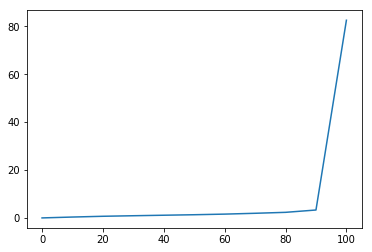

In [243]:
t = range(0,101,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

99.0 th percentile :  19.63632149985406
99.11111111111111 th percentile :  31.68439678888494
99.22222222222223 th percentile :  41.535800817665084
99.33333333333333 th percentile :  43.339586771510895
99.44444444444444 th percentile :  45.06761464189339
99.55555555555556 th percentile :  46.68699433404016
99.66666666666667 th percentile :  54.62190417904557
99.77777777777777 th percentile :  66.64210745626136
99.88888888888889 th percentile :  75.02188514028092
100.0 th percentile :  82.51198275414353


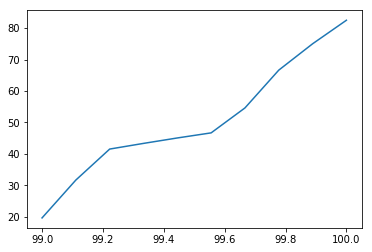

In [244]:
t = np.linspace(99,100,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [245]:
# Please write all the code with proper documentation
all_features = vectorizer.get_feature_names()

def most_informative_features(vectorizer, lr, n= 25):
    feature_names = all_features
    coefs_with_fns = sorted(zip(lr.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("_________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))
 


In [246]:
most_informative_features(X_train_bow,lr)

		Positive					Negative
_________________________________________________________________________________ 

	1.8518	amazing        				-1.5299	disappointed   
	1.6625	perfect        				-1.2900	money          
	1.6435	excellent      				-1.0010	stick          
	1.5841	delicious      				-0.7998	away           
	1.5318	pleased        				-0.7797	thought        
	1.4619	highly         				-0.7468	nothing        
	1.4241	smooth         				-0.7252	guess          
	1.3956	wonderful      				-0.6910	bad            
	1.2573	yummy          				-0.6908	rather         
	1.2346	awesome        				-0.6460	opened         
	1.2338	loves          				-0.6136	reviews        
	1.2224	glad           				-0.6096	tasted         
	1.2101	great          				-0.5683	received       
	1.1767	surprised      				-0.5632	left           
	1.1650	best           				-0.5628	service        
	1.1544	thank          				-0.5375	looked         
	1.0184	tasty          				-0.5335	cannot         
	1.0117	exactly        		

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [247]:
# Please write all the code with proper documentation
most_informative_features(X_train_bow,lr) 

		Positive					Negative
_________________________________________________________________________________ 

	1.8518	amazing        				-1.5299	disappointed   
	1.6625	perfect        				-1.2900	money          
	1.6435	excellent      				-1.0010	stick          
	1.5841	delicious      				-0.7998	away           
	1.5318	pleased        				-0.7797	thought        
	1.4619	highly         				-0.7468	nothing        
	1.4241	smooth         				-0.7252	guess          
	1.3956	wonderful      				-0.6910	bad            
	1.2573	yummy          				-0.6908	rather         
	1.2346	awesome        				-0.6460	opened         
	1.2338	loves          				-0.6136	reviews        
	1.2224	glad           				-0.6096	tasted         
	1.2101	great          				-0.5683	received       
	1.1767	surprised      				-0.5632	left           
	1.1650	best           				-0.5628	service        
	1.1544	thank          				-0.5375	looked         
	1.0184	tasty          				-0.5335	cannot         
	1.0117	exactly        		

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


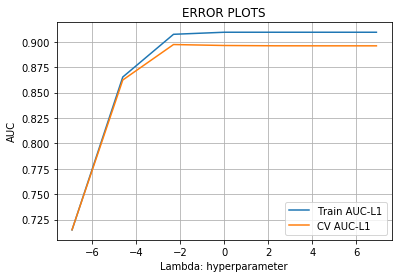

--------------------------
Cv auc scores with penalty L1
[0.7149699199648194, 0.8623288923876233, 0.8972410900489787, 0.896310926469845, 0.8960070373236244, 0.8959738297314899, 0.8959698161300508]
Maximun Auc value : 0.8972410900489787
Index 2
The optimal value of Lambda =  0.1


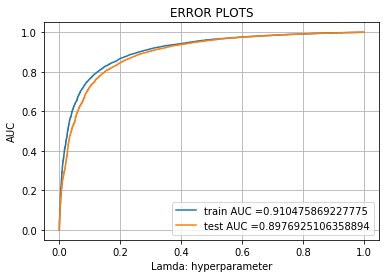

Train confusion matrix
[[ 6174  1081]
 [ 6539 31096]]
Test confusion matrix
[[ 4191   917]
 [ 4831 23061]]


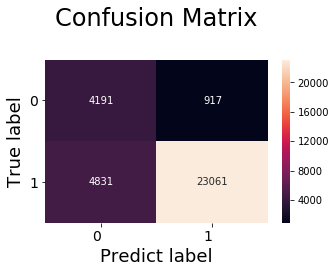

In [248]:
lr_all(X_train_tfidf,y_train,X_cv_tfidf,'l1')

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


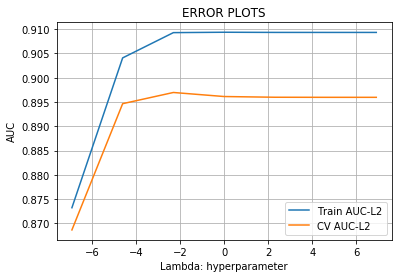

--------------------------
Cv auc scores with penalty L2
[0.8686668268851596, 0.8946634880571093, 0.8969706221466804, 0.8961376090875506, 0.8959898841372461, 0.8959746232952724, 0.895973127732759]
Maximun Auc value : 0.8969706221466804
Index 2
The optimal value of Lambda =  0.1


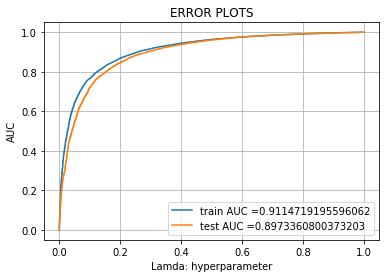

Train confusion matrix
[[ 6162  1093]
 [ 6475 31160]]
Test confusion matrix
[[ 4192   916]
 [ 4798 23094]]


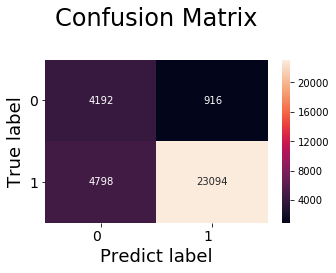

In [249]:
all_lr(X_train_tfidf,y_train,X_cv_tfidf,'l2')

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [250]:
# Please write all the code with proper documentation


# Please write all the code with proper documentation
all_features = tf_idf_vect.get_feature_names()

def most_informative_features(tf_idf_vect, lr, n= 25):
    feature_names = all_features
    coefs_with_fns = sorted(zip(lr.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("_________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))

In [251]:
most_informative_features(X_train_tfidf,lr) 

		Positive					Negative
_________________________________________________________________________________ 

	1.8518	amount         				-1.5299	drinking       
	1.6625	pieces         				-1.2900	never          
	1.6435	fan            				-1.0010	stores         
	1.5841	dog            				-0.7998	baby           
	1.5318	plus           				-0.7797	three          
	1.4619	house          				-0.7468	nuts           
	1.4241	smooth         				-0.7252	happy          
	1.3956	work           				-0.6910	bags           
	1.2573	yummy          				-0.6908	read           
	1.2346	back           				-0.6460	orange         
	1.2338	maybe          				-0.6136	review         
	1.2224	got            				-0.6096	tastes like    
	1.2101	gum            				-0.5683	reason         
	1.1767	take           				-0.5632	likes          
	1.1650	big            				-0.5628	service        
	1.1544	thanks         				-0.5375	makes          
	1.0184	tea            				-0.5335	cats           
	1.0117	family         		

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [252]:
# Please write all the code with proper documentation
most_informative_features(X_train_tfidf,lr) 

		Positive					Negative
_________________________________________________________________________________ 

	1.8518	amount         				-1.5299	drinking       
	1.6625	pieces         				-1.2900	never          
	1.6435	fan            				-1.0010	stores         
	1.5841	dog            				-0.7998	baby           
	1.5318	plus           				-0.7797	three          
	1.4619	house          				-0.7468	nuts           
	1.4241	smooth         				-0.7252	happy          
	1.3956	work           				-0.6910	bags           
	1.2573	yummy          				-0.6908	read           
	1.2346	back           				-0.6460	orange         
	1.2338	maybe          				-0.6136	review         
	1.2224	got            				-0.6096	tastes like    
	1.2101	gum            				-0.5683	reason         
	1.1767	take           				-0.5632	likes          
	1.1650	big            				-0.5628	service        
	1.1544	thanks         				-0.5375	makes          
	1.0184	tea            				-0.5335	cats           
	1.0117	family         		

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


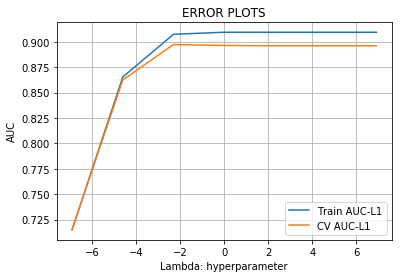

--------------------------
Cv auc scores with penalty L1
[0.7149699199648194, 0.8623289381701493, 0.8972420820037071, 0.8963110790782647, 0.8960064421507873, 0.8959732498194948, 0.8959688241753225]
Maximun Auc value : 0.8972420820037071
Index 2
The optimal value of Lambda =  0.1


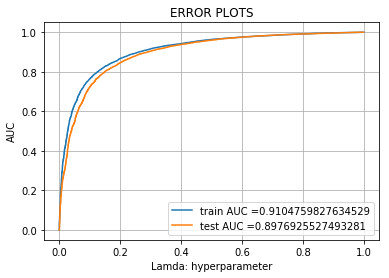

Train confusion matrix
[[ 6174  1081]
 [ 6539 31096]]
Test confusion matrix
[[ 4191   917]
 [ 4831 23061]]


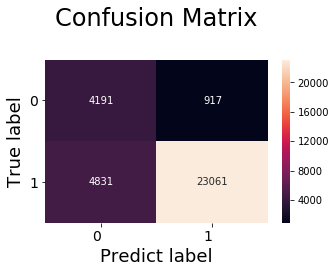

In [253]:
# Please write all the code with proper documentation

lr_all(train_vectors,y_train,X_cv,'l1')

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


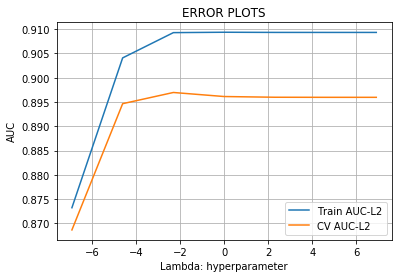

--------------------------
Cv auc scores with penalty L2
[0.8686668268851596, 0.8946634880571093, 0.8969706221466804, 0.8961376090875506, 0.8959898841372461, 0.8959746232952724, 0.895973127732759]
Maximun Auc value : 0.8969706221466804
Index 2
The optimal value of Lambda =  0.1


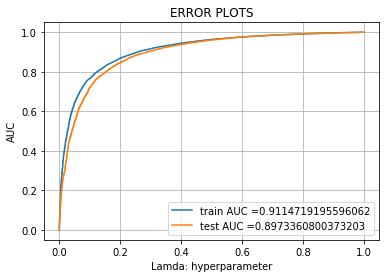

Train confusion matrix
[[ 6162  1093]
 [ 6475 31160]]
Test confusion matrix
[[ 4192   916]
 [ 4798 23094]]


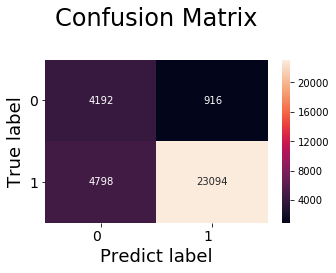

In [254]:
# Please write all the code with proper documentation
all_lr(train_vectors,y_train,X_cv,'l2')

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


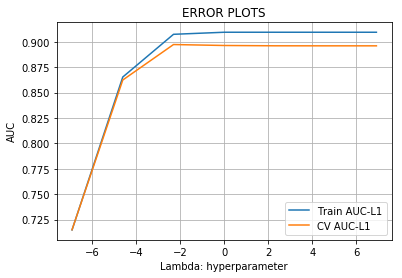

--------------------------
Cv auc scores with penalty L1
[0.7149699199648194, 0.8623300979941393, 0.897239838659937, 0.8963122846847806, 0.8960067473676269, 0.8959728377767614, 0.8959698161300507]
Maximun Auc value : 0.897239838659937
Index 2
The optimal value of Lambda =  0.1


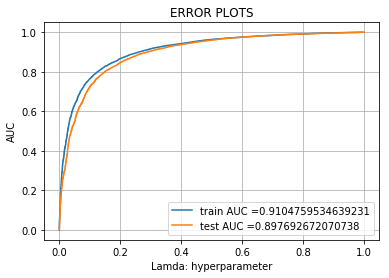

Train confusion matrix
[[ 6174  1081]
 [ 6539 31096]]
Test confusion matrix
[[ 4191   917]
 [ 4831 23061]]


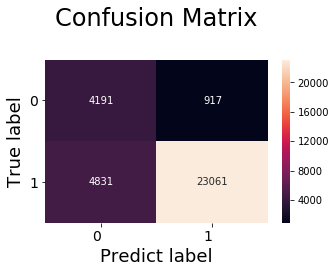

In [255]:
# Please write all the code with proper documentation
lr_all(tfidf_train_vectors,y_train,X_cv,'l1')

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


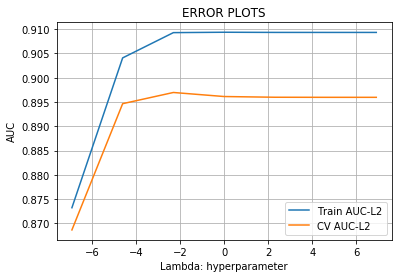

--------------------------
Cv auc scores with penalty L2
[0.8686668268851596, 0.8946634880571093, 0.8969706221466804, 0.8961376090875506, 0.8959898841372461, 0.8959746232952724, 0.895973127732759]
Maximun Auc value : 0.8969706221466804
Index 2
The optimal value of Lambda =  0.1


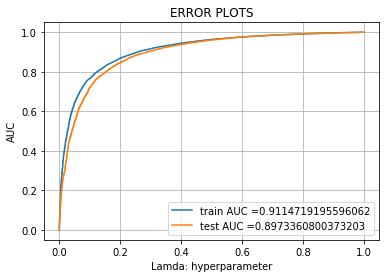

Train confusion matrix
[[ 6162  1093]
 [ 6475 31160]]
Test confusion matrix
[[ 4192   916]
 [ 4798 23094]]


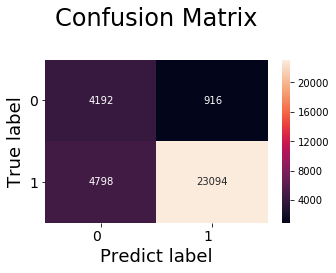

In [256]:
# Please write all the code with proper documentation

all_lr(tfidf_train_vectors,y_train,X_cv,'l2')

# [6] Conclusions

In [257]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable

# Names of models
Vectorizer = ['Bag of Words','Bag of Words','TFIDF ','TFIDF ','AVG W2V','AVG W2V','TFIDF W2V','TFIDF W2V' ]


Param=[0.1, 0.1,0.1,0.1,0.1, 0.1,0.1, 0.1]

auc =[0.89,0.89,0.89,0.89,0.89,0.89,0.89,0.89]
 
numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("MODEL",Vectorizer)
 
ptable.add_column("Hyper Parameter",Param)
ptable.add_column("AUC",auc)
 

print(ptable)

+-------+--------------+-----------------+------+
| S.NO. |    MODEL     | Hyper Parameter | AUC  |
+-------+--------------+-----------------+------+
|   1   | Bag of Words |       0.1       | 0.89 |
|   2   | Bag of Words |       0.1       | 0.89 |
|   3   |    TFIDF     |       0.1       | 0.89 |
|   4   |    TFIDF     |       0.1       | 0.89 |
|   5   |   AVG W2V    |       0.1       | 0.89 |
|   6   |   AVG W2V    |       0.1       | 0.89 |
|   7   |  TFIDF W2V   |       0.1       | 0.89 |
|   8   |  TFIDF W2V   |       0.1       | 0.89 |
+-------+--------------+-----------------+------+


### Conclution 

This LR classifier is faster than some of the previous models.
TFIDF and BOW  both L1 and L2 gave 89% AUC value.
The model can be improved  by taking more data points, and by taking some other features that may provide us with better insight about the data.